# Probabilistic Forecasting: Conformal Prediction

Conformal prediction is a framework for constructing prediction intervals that are guaranteed to contain the true value with a specified probability (coverage probability). It works by combining the predictions of a point-forecasting model with its past residuals—differences between previous predictions and actual values. These residuals help estimate the uncertainty in the forecast and determine the width of the prediction interval that is then added to the point forecast. Skforecast implements [Split Conformal Prediction (SCP)](https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html#the-split-method).

<p style="text-align: center">
    <img src="../img/conformal-regression.png" style="width: 450px">
    <br>
    <font size="2.5"> <i>Conformal regression turns point predictions into prediction intervals. Source: Introduction To Conformal Prediction With Python: A Short Guide For Quantifying Uncertainty Of Machine Learning Models
by Christoph Molnar https://leanpub.com/conformal-prediction</i></font>
</p>


<p style="text-align: center">
<video width="450" 
       autoplay 
       muted 
       loop 
       playsinline 
       style="border-radius: 8px; border: 1px solid #e0e0e0;">
    <source src="../img/probabilistic-forecasting-conformal.mp4" type="video/mp4">
</video>
<br>
<font size="2.5"> <i>Animation of probabilistic conformal prediction process.</i></font>
</p>

Conformal methods can also calibrate prediction intervals generated by other techniques, such as quantile regression or bootstrapped residuals. In this case, the conformal method adjusts the prediction intervals to ensure that they remain valid with respect to the coverage probability. Skforecast provides this functionality through the `ConformalIntervalCalibrator` transformer.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

There are several well-established <a href="https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html" target="_blank">methods for conformal prediction</a>, each with its own characteristics and assumptions. However, when applied to time series forecasting, their coverage guarantees are only valid for one-step-ahead predictions. For multi-step-ahead predictions, the coverage probability is not guaranteed. Skforecast implements Split Conformal Prediction (SCP) due to its simplicity and efficiency. 

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>

</div>

## Libraries and data

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme, plot_residuals, plot_prediction_intervals

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# Data
# ==============================================================================
data = fetch_dataset(name="ett_m2_extended")
data = data[[
    "OT",
    "day_of_week_cos",
    "day_of_week_sin",
    "hour_cos",
    "hour_sin",
    "month_cos",
    "month_sin",
    "week_cos",
    "week_sin",
    "year",
]]
data.head(2)

╭──────────────────────────────── ett_m2_extended ─────────────────────────────────╮
│ Description:                                                                     │
│ Data from an electricity transformer station was collected between July 2016 and │
│ July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data    │
│ points). Each data point consists of 8 features, including the date of the       │
│ point, the predictive value "Oil Temperature (OT)", and 6 different types of     │
│ external power load features: High UseFul Load (HUFL), High UseLess Load (HULL), │
│ Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),   │
│ Low UseLess Load (LULL). Additional variables are created based on calendar      │
│ information (year, month, week, day of the week, and hour). These variables have │
│ been encoded using the cyclical encoding technique (sin and cos transformations) │
│ to preserve the cyclical nature of the data.                                     │
│                                                                                  │
│ Source:                                                                          │
│ Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &      │
│ Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for   │
│ Long Sequence Time-Series Forecasting.                                           │
│ [10.48550/arXiv.2012.07436](https://arxiv.org/abs/2012.07436).                   │
│ https://github.com/zhouhaoyi/ETDataset                                           │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/ETTm2_extended.csv                                            │
│                                                                                  │
│ Shape: 69680 rows x 16 columns                                                   │
╰──────────────────────────────────────────────────────────────────────────────────╯

,OT,day_of_week_cos,day_of_week_sin,hour_cos,hour_sin,month_cos,month_sin,week_cos,week_sin,year
date,,,,,,,,,,
2016-07-01 00:00:00,38.661999,-0.900969,-0.433884,1.0,0.0,-0.866025,-0.5,-1.0,1.224647e-16,2016
2016-07-01 00:15:00,38.223000,-0.900969,-0.433884,1.0,0.0,-0.866025,-0.5,-1.0,1.224647e-16,2016


In [3]:
# Split train-calibration-test
# ==============================================================================
exog_features = data.columns.difference(['OT']).tolist()
end_train = '2017-10-01 23:59:00'
end_calibration = '2018-04-01 23:59:00'
data_train = data.loc[: end_train, :]
data_cal   = data.loc[end_train:end_calibration, :]
data_test  = data.loc[end_calibration:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates calibration: {data_cal.index.min()} --- {data_cal.index.max()}  (n={len(data_cal)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 00:00:00 --- 2017-10-01 23:45:00  (n=43968)
Dates calibration: 2017-10-02 00:00:00 --- 2018-04-01 23:45:00  (n=17472)
Dates test       : 2018-04-02 00:00:00 --- 2018-06-26 19:45:00  (n=8240)


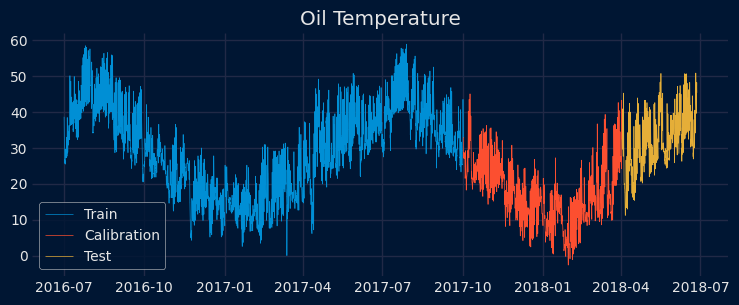

In [4]:
# Plot partitions
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'], label='Train')
ax.plot(data_cal['OT'], label='Calibration')
ax.plot(data_test['OT'], label='Test')
ax.set_title('Oil Temperature')
ax.legend();

## Calibration residuals

To address the issue of overoptimistic intervals, it is recommended to use out-of-sample residuals. These are residuals from a calibration set, which contains data not seen during training. These residuals can be obtained through backtesting.

In [5]:
# Create and fit forecaster
# ==============================================================================
params = {
    "max_depth": 4,
    "verbose": -1,
    "random_state": 15926
}
lags = [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73]
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)

forecaster = ForecasterRecursive(
                 estimator       = LGBMRegressor(**params),
                 lags            = lags,
                 window_features = window_features,
             )

forecaster.fit(
    y    = data.loc[:end_calibration, 'OT'],
    exog = data.loc[:end_calibration, exog_features]
)
forecaster

=================== 
ForecasterRecursive 
=================== 
Estimator: LGBMRegressor 
Lags: [ 1  2  3 23 24 25 47 48 49 71 72 73] 
Window features: ['roll_mean_72'] 
Window size: 73 
Series name: OT 
Exogenous included: True 
Exogenous names: 
    day_of_week_cos, day_of_week_sin, hour_cos, hour_sin, month_cos, month_sin,
    week_cos, week_sin, year 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2016-07-01 00:00:00'), Timestamp('2018-04-01 23:45:00')] 
Training index type: DatetimeIndex 
Training index frequency: <15 * Minutes> 
Estimator parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 4,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2026-01-29 14:26:47 
Last fit date: 2026-01-29 14:26:48 
Skforecast version: 0.20.0 
Python version: 3.13.11 
Forecaster id: None

In [ ]:
# Backtesting on calibration data to obtain out-of-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_train]),
         refit              = False
     )

_, predictions_cal = backtesting_forecaster(
                         forecaster    = forecaster,
                         y             = data.loc[:end_calibration, 'OT'],
                         exog          = data.loc[:end_calibration, exog_features],
                         cv            = cv,
                         metric        = 'mean_absolute_error',
                         n_jobs        = 'auto',
                         verbose       = False,
                         show_progress = True
                     )

  0%|          | 0/728 [00:00<?, ?it/s]

negative    12251
positive     5221
Name: count, dtype: int64


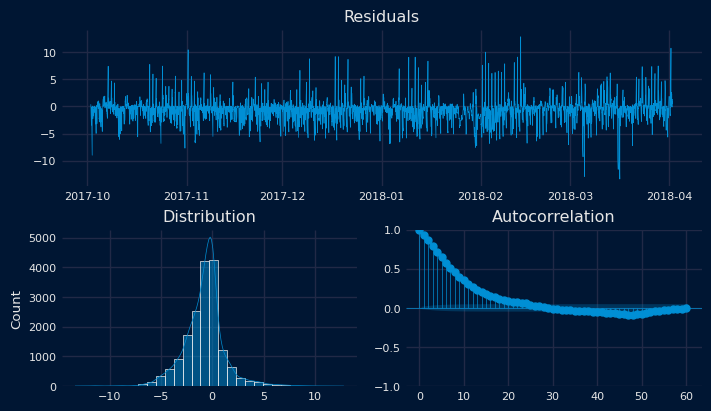

In [ ]:
# Distribution of out-of-sample residuals
# ==============================================================================
residuals = data.loc[predictions_cal.index, 'OT'] - predictions_cal['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

With the `set_out_sample_residuals()` method, the out-of-sample residuals are stored in the forecaster object so that they can be used to calibrate the prediction intervals.

In [ ]:
# Store out-of-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_cal.index, 'OT'], 
    y_pred = predictions_cal['pred']
)

Now that the new residuals have been added to the forecaster, the prediction intervals can be calculated using `use_in_sample_residuals = False`.

In [9]:
# Prediction intervals
# ==============================================================================
forecaster.predict_interval(
    steps                   = 24,
    exog                    = data.loc[end_calibration:, exog_features],
    interval                = [10, 90],
    method                  = 'conformal',
    use_in_sample_residuals = False,
    use_binned_residuals    = True
)

,pred,lower_bound,upper_bound
2018-04-02 00:00:00,32.024773,29.387492,34.662053
2018-04-02 00:15:00,31.853564,29.216283,34.490845
2018-04-02 00:30:00,31.695225,29.057944,34.332506
2018-04-02 00:45:00,31.442913,28.805632,34.080194
2018-04-02 01:00:00,31.390724,28.753443,34.028005
2018-04-02 01:15:00,31.137807,28.500526,33.775088
2018-04-02 01:30:00,30.926586,28.289305,33.563867
2018-04-02 01:45:00,30.793334,28.156053,33.430615
2018-04-02 02:00:00,30.544763,27.907482,33.182044
2018-04-02 02:15:00,30.544763,27.907482,33.182044


It is also possible to use forecast prediction intervals within a backtesting loop.

In [ ]:
# Backtesting with prediction intervals in test data using out-of-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_calibration]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'conformal',
                          use_in_sample_residuals = False,  # Use out-of-sample residuals
                          use_binned_residuals    = True    # Adaptive conformal 
                      )
predictions.head(5)

  0%|          | 0/344 [00:00<?, ?it/s]

,fold,pred,lower_bound,upper_bound
2018-04-02 00:00:00,0,32.024773,29.387492,34.662053
2018-04-02 00:15:00,0,31.853564,29.216283,34.490845
2018-04-02 00:30:00,0,31.695225,29.057944,34.332506
2018-04-02 00:45:00,0,31.442913,28.805632,34.080194
2018-04-02 01:00:00,0,31.390724,28.753443,34.028005


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Two arguments control the use of residuals in `predict()` and `backtesting_forecaster()`:

+ `use_in_sample_residuals`: If `True`, the in-sample residuals are used to compute the prediction intervals. Since these residuals are obtained from the training set, they are always available, but usually lead to overoptimistic intervals. If `False`, the out-of-sample residuals (calibration) are used to calculate the prediction intervals. These residuals are obtained from the validation/calibration set and are only available if the `set_out_sample_residuals()` method has been called. It is recommended to use out-of-sample residuals to achieve the desired coverage.

+ `use_binned_residuals`: If `False`, a single correction factor is applied to all predictions during conformalization. If `True`, the conformalization process uses a correction factor that depends on the bin where the prediction falls. This can be thought as a type of <b>Adaptive Conformal Predictions</b> and it can lead to more accurate prediction intervals since the correction factor is conditioned on the region of the prediction space.

</div>

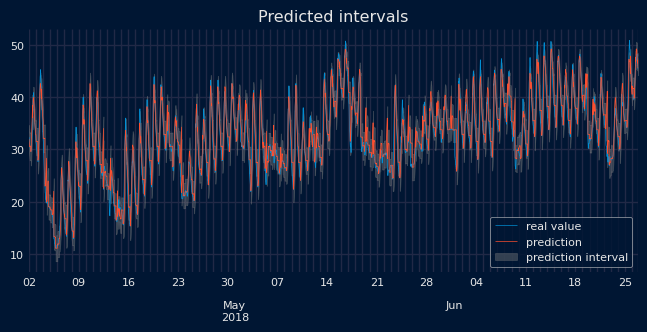

In [11]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "OT",
    title               = "Predicted intervals",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.4, 'zorder': 1}
)

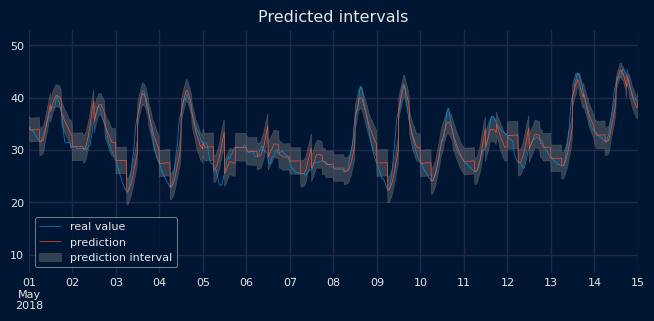

In [12]:
# Plot intervals with zoom ['2018-05-01', '2018-05-15']
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "OT",
    initial_x_zoom      = ['2018-05-01', '2018-05-15'],
    title               = "Predicted intervals",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.4, 'zorder': 1}
);

In [13]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_calibration:, 'OT'],
               lower_bound = predictions["lower_bound"], 
               upper_bound = predictions["upper_bound"]
           )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 79.32 %
Area of the interval: 38409.35


The prediction intervals generated using conformal prediction achieve an empirical coverage very close to the nominal coverage of 80%.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff9100;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
<b>Probabilistic forecasting in production</b>

The correct estimation of prediction intervals with conformal methods depends on the residuals being representative of future errors. For this reason, calibration residuals should be used. However, the dynamics of the series and models can change over time, so it is important to monitor and regularly update the residuals. It can be done easily using the <code>set_out_sample_residuals()</code> method.
</p>

</div>